# WaterTAP Academy Week 3 Hands-On Tutorial  
## Techno-Economic Analysis of an RO Flowsheet with an ERD

In this week’s hands-on tutorial, we will use WaterTAP to perform a Techno-Economic Analysis (TEA) on the flowsheet shown below: a single-stage Reverse Osmosis (RO) system equipped with an Energy Recovery Device (ERD). This example builds directly on the Week 2 after-session assignment.

<center><img src="./graphics/RO_with_ERD.png" width="600" /></center>

In the previous tutorial, we introduced how to add costing blocks on top of individual unit models for TEA. Now we will extend those concepts to the **flowsheet level**, demonstrating how performance modeling, costing, and optimization come together for system-wide analysis.

---

## In this tutorial, we will work through the following parts:

**Part 0 – Develop the Process Model**  
- Build the RO flowsheet and set up a full process simulation for performance prediction.

**Part 1 – Add WaterTAP Costing for TEA**  
- Integrate WaterTAP’s costing framework to complete the TEA model.  
- Compute key economic and energy metrics, such as Levelized Cost of Water (LCOW)

**Part 2 – Visualize TEA Results**  
- Plot and interpret system performance and cost results.

**Part 3 – Optimization Study for Cost Minimization**  
- Modify the model to set up and solve an optimization problem aiming to minimize LCOW.  
- Review the resulting optimal operating conditions.

**Part 4 – Try It Yourself: Visualize Optimization Results**  
- Create additional visualizations or summary plots for the optimization study.





---
## By the end of this tutorial, you should be able to:

- Build a simple RO flowsheet from scratch in WaterTAP.  
- Run a process simulation to predict system performance.  
- Apply WaterTAP costing to carry out a basic TEA.  
- Calculate key metrics such as LCOW.
- Set up and run an optimization to minimize LCOW.  
- Visualize and summarize your simulation and optimization results.


---

## **Part 0 – Develop the Process Model (4 Steps)** 

In this part, we will build a predictive process model of the RO flowsheet with ERD.
All steps and code used here were covered in the previous session, so this section serves as a quick review of how to construct a working flowsheet simulation before moving on to TEA and optimization.

1. **Import Required Modules**  
2. **Create the Process Model**  
3. **Solve the Model**  
4. **Check the Model Prediction**


---

### **Step 0: Import Required Modules**
Import all WaterTAP, Pyomo, and helper modules needed for building and solving the RO flowsheet.




In [1]:
# Imports from Pyomo
from pyomo.environ import (
    ConcreteModel,
    Var,
    Param,
    Constraint,
    Objective,
    value,
    assert_optimal_termination,
    TransformationFactory,
    units as pyunits,
)
from pyomo.network import Arc

# Imports from IDAES
from idaes.core import FlowsheetBlock
from idaes.models.unit_models import Feed, Product
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.util.scaling import calculate_scaling_factors, set_scaling_factor
from idaes.core.util.initialization import propagate_state

# Imports from WaterTAP
from watertap.property_models.seawater_prop_pack import SeawaterParameterBlock
from watertap.unit_models.pressure_changer import Pump
from watertap.unit_models.pressure_changer import EnergyRecoveryDevice
from watertap.unit_models.reverse_osmosis_0D import (
    ReverseOsmosis0D,
    ConcentrationPolarizationType,
    MassTransferCoefficient,
    PressureChangeType,
)
from watertap.core.solvers import get_solver


### **Step 1: Create the Process Model**
- Define the main Pyomo model using **`ConcreteModel()`**.  
- Build the WaterTAP flowsheet using **`FlowsheetBlock()`**.  
- Define the water chemistry using **`SeawaterParameterBlock()`**, which provides the property package for the RO system.  
- Add the required unit models, including:  
  - `Feed()`  
  - `Pump()`  
  - `ReverseOsmosis0D()`  
  - `EnergyRecoveryDevice()`  
  - `Product()`  
- Connect the units using process streams (via **`Arc`**) to form the complete flowsheet.




In [2]:
# Create a model object using ConcreteModel
m = ConcreteModel()
# Add the flowsheet to the model using FlowsheetBlock
m.fs = FlowsheetBlock(dynamic=False)
# Add the Seawater property package
m.fs.properties = SeawaterParameterBlock()

<center><img src="./graphics/RO_with_ERD.png" width="600" /></center>

In [3]:
# Add feed
m.fs.feed = Feed(property_package=m.fs.properties)
# Set feed stream
m.fs.feed.properties[0].flow_vol_phase["Liq"].fix(1e-3)
m.fs.feed.properties[0].conc_mass_phase_comp["Liq", "TDS"].fix(35)
m.fs.feed.properties[0].pressure.fix(101325)
m.fs.feed.properties[0].temperature.fix(273.15 + 25)


# Add pump
m.fs.pump = Pump(property_package=m.fs.properties)
# Set pump parameters
m.fs.pump.efficiency_pump.fix(0.80)
m.fs.pump.control_volume.properties_out[0].pressure.fix(75 * pyunits.bar)


# Add 0D reverse osmosis unit
m.fs.RO = ReverseOsmosis0D(
    property_package=m.fs.properties,
    has_pressure_change=True,
    pressure_change_type=PressureChangeType.calculated,
    mass_transfer_coefficient=MassTransferCoefficient.calculated,
    concentration_polarization_type=ConcentrationPolarizationType.calculated,
)
# Set RO parameters
m.fs.RO.A_comp.fix(4.2e-12)
m.fs.RO.B_comp.fix(3.5e-8)
m.fs.RO.recovery_vol_phase[0, "Liq"].fix(0.5)
m.fs.RO.feed_side.channel_height.fix(1e-3)
m.fs.RO.feed_side.spacer_porosity.fix(0.97)
m.fs.RO.permeate.pressure[0].fix(101325)
m.fs.RO.area.fix(50)

# Add Energy Recovery Device 
m.fs.erd = EnergyRecoveryDevice(property_package=m.fs.properties)
# Set ERD parameters
m.fs.erd.efficiency_pump.fix(0.95)
m.fs.erd.outlet.pressure[0].fix(101325)

# Add product stream
m.fs.product = Product(property_package=m.fs.properties)

In [4]:
# Define the connectivity using Arcs
m.fs.feed_to_pump = Arc(source=m.fs.feed.outlet, destination=m.fs.pump.inlet)
m.fs.pump_to_RO = Arc(source=m.fs.pump.outlet, destination=m.fs.RO.inlet)
m.fs.RO_to_erd = Arc(source=m.fs.RO.retentate, destination=m.fs.erd.inlet)
m.fs.RO_to_product = Arc(source=m.fs.RO.permeate, destination=m.fs.product.inlet)

# Use the TransformationFactory to expand the arcs
TransformationFactory("network.expand_arcs").apply_to(m)

### **Step 2: Solve the Model**
- Apply appropriate scaling factors for model stability.  
- Initialize each unit model to provide good starting guesses.  
- Solve the full flowsheet using a nonlinear solver to obtain predictive model results.

In [5]:
# Set Scaling factors
m.fs.properties.set_default_scaling("flow_mass_phase_comp", 1, index=("Liq", "H2O"))
m.fs.properties.set_default_scaling("flow_mass_phase_comp", 1e2, index=("Liq", "TDS"))
set_scaling_factor(m.fs.pump.control_volume.work, 1e-3)
set_scaling_factor(m.fs.RO.area, 1e-2)
calculate_scaling_factors(m)

2025-12-04 07:55:47 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.erd.control_volume.work


In [6]:
# Get WaterTAP solver
solver = get_solver()
solver.solve(m.fs.feed)
# Propagate state from feed to pump
propagate_state(m.fs.feed_to_pump)
# Initialize pump
m.fs.pump.initialize()
# Propagate state from pump to RO
propagate_state(m.fs.pump_to_RO)
# Initialize RO
m.fs.RO.initialize()
# Propagate state from RO to ERD and product
propagate_state(m.fs.RO_to_erd)
propagate_state(m.fs.RO_to_product)
# Initialize the product and ERD
m.fs.product.initialize()
m.fs.erd.initialize()

2025-12-04 07:55:50 [INFO] idaes.init.fs.pump.control_volume.properties_out: fs.pump.control_volume.properties_out State Released.
2025-12-04 07:55:50 [INFO] idaes.init.fs.pump.control_volume: Initialization Complete
component keys that are not exported as part of the NL file.  Skipping.
that are not Var, Constraint, Objective, or the model.  Skipping.
2025-12-04 07:55:50 [INFO] idaes.init.fs.pump.control_volume.properties_in: fs.pump.control_volume.properties_in State Released.
2025-12-04 07:55:50 [INFO] idaes.init.fs.pump: Initialization Complete: optimal - Optimal Solution Found
2025-12-04 07:55:51 [INFO] idaes.init.fs.RO.feed_side.properties_out: fs.RO.feed_side.properties_out State Released.
2025-12-04 07:55:51 [INFO] idaes.init.fs.RO.feed_side.properties_interface: fs.RO.feed_side.properties_interface State Released.
2025-12-04 07:55:51 [INFO] idaes.init.fs.RO.feed_side: Initialization Complete
2025-12-04 07:55:52 [INFO] idaes.init.fs.RO.permeate_side: fs.RO.permeate_side State R

In [7]:
print("DOF = ", degrees_of_freedom(m))
# Solve the model and assert the the model has reached optimal termination
results = solver.solve(m, tee=False)
assert_optimal_termination(results)
print(
    f"Solver Status: {results.solver.status}, Termination Condition: {results.solver.termination_condition}"
)

DOF =  0
Solver Status: ok, Termination Condition: optimal


### **Step 3: Check the Model Prediction**
- Inspect key output variables such as flows, pressures, recovery, and concentrations.  
- Verify that the model behavior is physically reasonable before proceeding.

In [8]:
# Report unit-level performance results for (1) the pump, (2) RO and (3) the energy recovery device, using the report() method for each unit on the flowsheet.
m.fs.pump.report()
m.fs.RO.report()
m.fs.erd.report()


Unit : fs.pump                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value      : Units         : Fixed : Bounds
         Efficiency :    0.80000 : dimensionless :  True : (None, None)
    Mechanical Work :     9248.3 :          watt : False : (None, None)
    Pressure Change : 7.3987e+06 :        pascal : False : (None, None)
     Pressure Ratio :     74.019 : dimensionless : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                              Units           Inlet     Outlet  
    flow_mass_phase_comp ('Liq', 'H2O')  kilogram / second    0.98796    0.98796
    flow_mass_phase_comp ('Liq', 'TDS')  kilogram / second   0.035000   0.035000
    temperature                                     kelvin     298.15     298.15
    press

## **Part 1 – Develop TEA Model (4 Steps)**

In this part, we will use WaterTAP costing functionality to develop a complete TEA model. 4 Steps are needed:

1. Import Required Modules  
2. Build TEA Model   
3. Connect Process Model with TEA Model  
4. Solve Combined Process and TEA Model


---

### **Step 0: Import Required Modules**

In [9]:
# Import costing package
from watertap.costing import WaterTAPCosting
from idaes.core import UnitModelCostingBlock

### **Step 1: Build TEA Model**
- Add a **costing block** for the overall flowsheet using `WaterTAPCosting()`.  
- Add **costing add-ons** to individual unit models using `UnitModelCostingBlock()`
- Process the costing information

In [10]:
# Add costing
m.fs.costing = WaterTAPCosting()
m.fs.costing.base_currency = pyunits.USD_2020
m.fs.pump.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
m.fs.RO.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
m.fs.erd.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)

# Process costing 
m.fs.costing.cost_process()

2025-12-04 07:56:03 [WARNING] idaes.core.base.costing_base: flow_expr is an expression with a lower bound of less than zero. Costing requires that all flows have a lower bound equal to or greater than zero to avoid negative costs.


### **Step 2: Connect Process Model with TEA Model** 

In [11]:
# Add system level metrics
m.fs.costing.add_annual_water_production(m.fs.product.properties[0].flow_vol)
m.fs.costing.add_LCOW(m.fs.product.properties[0].flow_vol)
m.fs.costing.add_specific_energy_consumption(m.fs.product.properties[0].flow_vol)

### **Step 3: Solve the Combined Process and TEA Model**

In [12]:
# Initialize costing
m.fs.costing.initialize()

# ReSolve the model and assert the the model has reached optimal termination
results = solver.solve(m, tee= False)
assert_optimal_termination(results)
print(
    f"Solver Status: {results.solver.status}, Termination Condition: {results.solver.termination_condition}"
)

Solver Status: ok, Termination Condition: optimal


## **Part 2 – Visualize TEA Results (3 Steps)**

In this part, we will analyze and visualize the results from the TEA model.  
We will extract key economic metrics, examine the detailed cost breakdown, and create plots to better understand the contributions to the Levelized Cost of Water (LCOW). Steps for Visualizing TEA Results

1. Print Key Metrics
2. Get LCOW Breakdown  
3. Visualize LCOW Breakdown


### **Step 1: Print Key Metrics**

In [13]:
# Display costing metrics
print("Levelized cost of water: %.2f $/m3" % value(m.fs.costing.LCOW))
print("Total operating cost: %.4g $/yr" % value(m.fs.costing.total_operating_cost))
print("Total capital cost: %.4g $" % value(m.fs.costing.total_capital_cost))
print("Total annualized cost: %.4g $/yr" % value(m.fs.costing.total_annualized_cost))
print("Specific energy consumption: %.1f kWh/m3" % value(m.fs.costing.specific_energy_consumption))

Levelized cost of water: 0.61 $/m3
Total operating cost: 4756 $/yr
Total capital cost: 3.976e+04 $
Total annualized cost: 8732 $/yr
Specific energy consumption: 3.3 kWh/m3


### **Step 2: Get the LCOW Breakdown**

In [14]:
def get_break_down_values(m):
    try:
        return {
            # --- Capital Expenditure (CAPEX) Components (Annualized to LCOW) ---
            # 1. Direct CAPEX for Pump
            "Pump CAPEX": value(m.fs.costing.LCOW_aggregate_direct_capex["Pump"]),
            # 2. Direct CAPEX for RO Unit (e.g., pressure vessels, piping)
            "RO CAPEX": value(m.fs.costing.LCOW_aggregate_direct_capex["ReverseOsmosis0D"]),
            # 3. Direct CAPEX for Energy Recovery Device (ERD)
            "ERD CAPEX": value(m.fs.costing.LCOW_aggregate_direct_capex["EnergyRecoveryDevice"]),
            # 4. Indirect CAPEX (Aggregates items like engineering, contingency, etc.)
            "Indirect CAPEX": value(sum(i for i in m.fs.costing.LCOW_aggregate_indirect_capex.values())),
            
            # --- Operating Expenditure (OPEX) Components (normalized to LCOW) ---
            # 5. RO Fixed OPEX (Membrane replacement, maintenance)
            "RO OPEX": value(m.fs.costing.LCOW_aggregate_fixed_opex["ReverseOsmosis0D"]),
            # 6. Electricity OPEX (Variable OPEX, calculated from Specific Energy Consumption)
            "Electricity": value(m.fs.costing.LCOW_aggregate_variable_opex["electricity"]),
            # 7. Other Fixed OPEX (All remaining fixed OPEX components, excluding RO OPEX)
            "Other OPEX": value(
                sum(i for i in m.fs.costing.LCOW_aggregate_fixed_opex.values()) -
                m.fs.costing.LCOW_aggregate_fixed_opex["ReverseOsmosis0D"]
            )
        }

    except Exception as e:
        print(f"Error extracting breakdown values. Ensure the model is solved and costing is completed: {e}")
        return {}
    

In [15]:
simulation_results = get_break_down_values(m)
simulation_results

{'Pump CAPEX': 0.12283680070144336,
 'RO CAPEX': 0.010441849317311966,
 'ERD CAPEX': 0.006711851450561746,
 'Indirect CAPEX': 0.13999050146931707,
 'RO OPEX': 0.027148808225011114,
 'Electricity': 0.23000544729481467,
 'Other OPEX': 0.07772919129120306}

In [ ]:
# Bonus Function
def table_view(simulation_results):
    """
    Prints LCOW breakdown results in a simple, readable table format

    Args:
        simulation_results (dict): A dictionary of LCOW cost component.
    """
    key_width = max(len("Cost Breakdown"), max(len(k) for k in simulation_results.keys()))
    value_width = 10 
    total_width = key_width + value_width + 5
    separator = "-" * total_width
    total_lcow = 0

    print(separator)
    print(f"| {'Cost Breakdown':<{key_width}} | {'Value ($/m³)':>{value_width}} |")
    print(separator)

    for component, value in simulation_results.items():
        print(f"| {component:<{key_width}} | {value:>{value_width}.3f} |")
        total_lcow += value
        
    print(separator)
    print(f"| {'TOTAL LCOW':<{key_width}} | {total_lcow:>{value_width}.3f} |")
    print(separator)

In [ ]:
table_view(simulation_results)

-----------------------------
| Cost Breakdown | Value ($/m³) |
-----------------------------
| Pump CAPEX     |      0.123 |
| RO CAPEX       |      0.010 |
| ERD CAPEX      |      0.007 |
| Indirect CAPEX |      0.140 |
| RO OPEX        |      0.027 |
| Electricity    |      0.230 |
| Other OPEX     |      0.078 |
-----------------------------
| TOTAL LCOW     |      0.615 |
-----------------------------


### **Step 3: Visualize the LCOW Breakdown**

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Bonus Function
def visualize_breakdown(breakdown_data_dict, title="LCOW Breakdown", barwidth=0.4):
    if not breakdown_data_dict:
        print("No data provided for visualization.")
        return

    categories = list(breakdown_data_dict.keys())
    
    # Get the list of all cost component labels (e.g., "Pump CAPEX")
    first_dict = next(iter(breakdown_data_dict.values()), None)
    if not first_dict:
        print("Breakdown dictionary is empty.")
        return
        
    labels = list(first_dict.keys())
    
    # Restructure data: plot_data will hold the values for stacking the bars.
    # Each inner list corresponds to one cost component (label) across all scenarios.
    plot_data = []
    for label in labels:
        # Collect the value for the current cost component (label) from every scenario dict
        plot_data.append([d.get(label, 0) for d in breakdown_data_dict.values()])

    # 2. Configure the plot
    x = np.arange(len(categories))
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # 'bottom' tracks the current vertical position for stacking the bars
    bottom = np.zeros(len(categories))
    
    # 3. Draw the stacked bars
    for group, label in zip(plot_data, labels):
        # Draw bars for the current cost component (group) stacked on the 'bottom'
        bars = ax.bar(x, group, width=barwidth, bottom=bottom, label=label)
        
        # Add numerical labels to the center of each bar segment
        for bar, value in zip(bars, group):
            height = bar.get_height()
            # Only label non-zero values for cleaner visualization
            if value > 1e-4:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + height / 2,
                    f"{value:.3f}", # Format the value to 3 decimal places
                    ha='center',
                    va='center',
                    fontsize=8,
                    color='black'
                )
        
        # Update the bottom position for the next stack layer
        bottom += group

    # 4. Final plot aesthetics
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.set_xlim(-0.5, len(categories) - 0.5)  
    ax.set_ylabel('Levelized Cost of Water ($/m3)')
    ax.set_title(title)
    # Legend placed above the plot for clear viewing
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=4)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

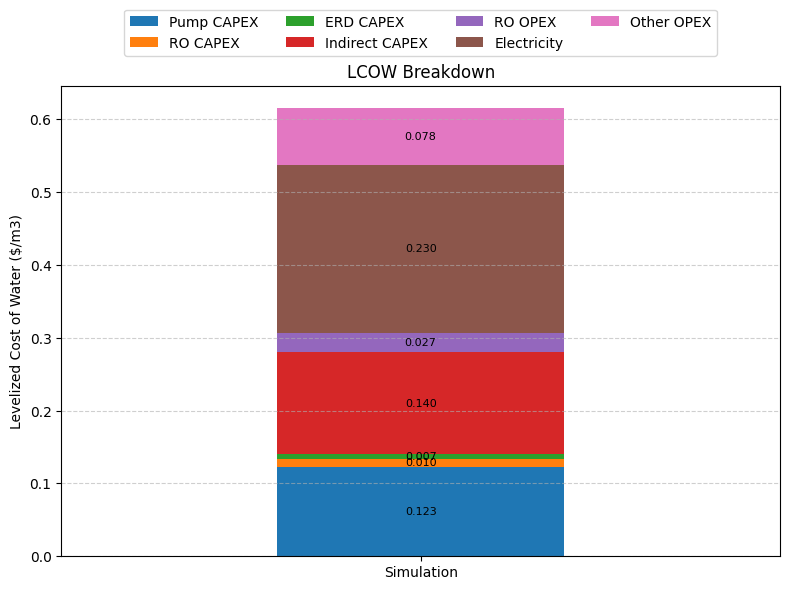

In [26]:
breakdown_data_dict = {"Simulation":simulation_results }
visualize_breakdown(breakdown_data_dict)

## **Part 3 – Optimization Study for Cost Minimization (4 Steps)**

In this part, we will set up and solve an optimization problem to minimize the Levelized Cost of Water (LCOW).  
The optimization problem aims to identify the optimal RO operating area and feed pressure to achieve the lowest LCOW.  
There are constraints on **minimum water flux** and **maximum product water salinity** to ensure feasible and practical operation.  

The optimization study will be conducted in the following four steps:

1. Free decision variables in Pump and RO  
2. Add process requirements (e.g., product water salinity and minimum water flux)  
3. Add objective function to minimize LCOW  
4. Solve the optimization problem


### **Step 1: Free Decision Variables**

In [27]:
# Unfix decision variables - pump
m.fs.pump.control_volume.properties_out[0].pressure.unfix()
m.fs.pump.control_volume.properties_out[0].pressure.setlb(10e5)
m.fs.pump.control_volume.properties_out[0].pressure.setub(85e5)
m.fs.pump.deltaP.setlb(0)

# Unfix decision variables - RO
m.fs.RO.area.unfix()
m.fs.RO.area.setlb(1)
m.fs.RO.area.setub(1500)
m.fs.RO.feed_side.friction_factor_darcy[...].setub(None)

[None, None]

### **Step 2: Add Process Requirements**

In [28]:
# Add extra process requirement constraints
m.fs.product_salinity = Param(
    initialize=500e-6, mutable=True
)  # product NaCl mass fraction [-]
m.fs.minimum_water_flux = Param(
    initialize=1.0 / 3600.0, mutable=True
)  # minimum water flux [kg/m2-s]
m.fs.eq_product_quality = Constraint(
    expr=m.fs.product.properties[0].mass_frac_phase_comp["Liq", "TDS"]
    <= m.fs.product_salinity
)
m.fs.eq_minimum_water_flux = Constraint(
    expr=m.fs.RO.flux_mass_phase_comp[0, 1, "Liq", "H2O"] >= m.fs.minimum_water_flux
)


### **Step 3: Add Objective Function**

In [29]:
# Add objective function
m.fs.objective = Objective(expr=m.fs.costing.LCOW)

### **Step 4: Solve the Optimization Problem**

In [31]:
# Solve the optimization
results = solver.solve(m, tee = False)
assert_optimal_termination(results)
print(
    f"Solver Status: {results.solver.status}, Termination Condition: {results.solver.termination_condition}"
)

Solver Status: ok, Termination Condition: optimal


In [33]:
# Display decision variables
print("Optimal operating pressure %.1f bar" % (m.fs.RO.inlet.pressure[0].value / 1e5))
print("Optimal membrane area %.1f m2" % (m.fs.RO.area.value))

Optimal operating pressure 50.0 bar
Optimal membrane area 132.3 m2


**Part 4 – Try It Yourself: Visualize Optimization Results**  

In [19]:
# Display costing metrics
print("Levelized cost of water: %.2f $/m3" % value(m.fs.costing.LCOW))

Levelized cost of water: 0.50 $/m3


In [20]:
# Display decision variables
print("Operating pressure %.1f bar" % (m.fs.RO.inlet.pressure[0].value / 1e5))
print("Membrane area %.1f m2" % (m.fs.RO.area.value))

Operating pressure 50.0 bar
Membrane area 132.3 m2


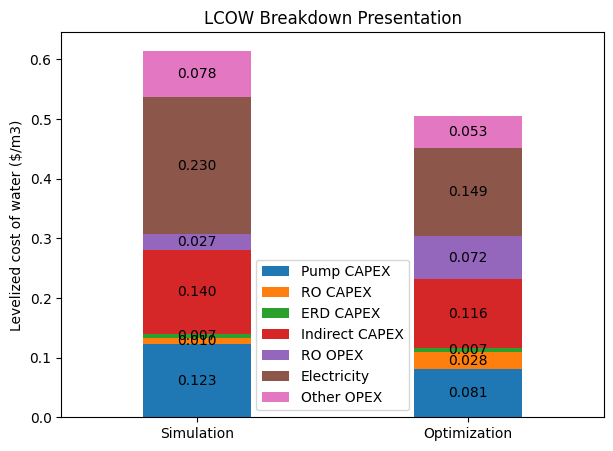

In [21]:
# Plot LCOW breakdown
opt_capex_pump = value(m.fs.costing.LCOW_aggregate_direct_capex["Pump"])
opt_capex_RO = value(m.fs.costing.LCOW_aggregate_direct_capex["ReverseOsmosis0D"])
opt_capex_erd = value(m.fs.costing.LCOW_aggregate_direct_capex["EnergyRecoveryDevice"])
opt_capex_indirect = value(sum(i for i in m.fs.costing.LCOW_aggregate_indirect_capex.values()))
opt_opex_RO = value(m.fs.costing.LCOW_aggregate_fixed_opex["ReverseOsmosis0D"])
opt_opex_elec = value(m.fs.costing.LCOW_aggregate_variable_opex["electricity"])
opt_opex_other = value(sum(i for i in m.fs.costing.LCOW_aggregate_fixed_opex.values())-m.fs.costing.LCOW_aggregate_fixed_opex["ReverseOsmosis0D"])
opt_LCOW_breakdown_value = [opt_capex_pump, opt_capex_RO, opt_capex_erd, opt_capex_indirect, opt_opex_RO, opt_opex_elec, opt_opex_other]
LCOW_breakdwon_dict = ["Pump CAPEX", "RO CAPEX", "ERD CAPEX", "Indirect CAPEX", "RO OPEX", "Electricity", "Other OPEX"]

categories = ["Simulation", "Optimization"]
x = np.arange(len(categories))
data = [[i, j] for i, j in zip(sim_LCOW_breakdown_value, opt_LCOW_breakdown_value)]
label = LCOW_breakdwon_dict
barwidth = 0.4
ax = plot_lcow_breakdown(x, categories, data, label, barwidth)
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_xlim(-0.5, len(categories)-0.5)  
ax.set_ylabel('Levelized cost of water ($/m3)')
ax.set_title('LCOW Breakdown Presentation')
ax.legend()

plt.show()